In [1]:
import numpy as np
import itertools
%matplotlib inline
from matplotlib import pyplot as plt
from functools import partial
from tqdm import tqdm

Testing the following equations for $\Delta(w,u)=f(w+u)-f(w)$
$$
\mathbb{E}\Delta(w,u)=f'_i\mathbb{E}u+\frac{1}{2}f''_{ii}\mathbb{V}ar u+\frac{1}{2}\mathbb{E}u^Tf''_{ij}\mathbb{E}u+\mathcal{O}(\alpha^3)
$$

$$
\mathbb{E}\Delta(w,u)=(f'_i)^2\mathbb{V}ar u+(f'_{i}\mathbb{E} u)^2+\mathcal{O}(\alpha^3)
$$

Will use Gaussian input $\mathbb{R}^d\ni x\sim N(\mu_x,\sigma_x^2 I)$, one hidden layer with $\sigma(x)=\frac{1}{1+e^{-x}}$ and Gaussian weights $w\in\mathbb{R}^d$ with $w\sim N(\mu_w,\sigma_w^2 I)$

The distribution of crashes of inputs is Bernoulli with parameter $p$.

In [2]:
# see parameter description in latex above
mu_x = 1
sigma_x = 0.2
mu_w = 0.05
sigma_w = 0.1
d = 10
p = 0.1

In [3]:
# generating x and w
x = np.random.randn(d, 1) * sigma_x + mu_x
w = np.random.randn(d, 1) * sigma_w + mu_w

In [4]:
def sigma(x):
    """ Activation fcn """
    return 1. / (1 + np.exp(-x))

def sigma_dot(x):
    """ Derivative of sigma """
    return sigma(x) * (1. - sigma(x))

def sigma_ddot(x):
    """ Double derivative of sigma """
    return sigma(x) * (1. - sigma(x)) * (1. - 2 * sigma(x))

In [5]:
def compute_mean_and_var_bernoulli_twosided(fcn, p, threshold = lambda x : True):
    """ Compute expectation and variance of fcn given Bernoulli crashes w.p. p
        Two sided: w.p. p/2 +x, w.p. p/2 -x
    """
    # all combinations
    combinations = list(itertools.product([0, 1, 2], repeat=len(x)))
    
    # resulting expectation of fcn
    result_f = 0.
    
    # resulting expectation of fcn^2
    result_f_sq = 0.
    
    # number of entries in x
    n = len(x)

    # all probs
    probs = 0
    
    for c in combinations:
        # crashing inputs
        x1 = np.multiply(x.reshape(-1), c)
        
        # number of crashes
        k = len(c) - np.sum(np.array(c) != 1)
        
        # probability of this event
        prob = p ** k * (1 - p) ** (n - k) / 2
        
        # how much vector is changed in norm?
        alpha = np.linalg.norm(x.reshape(-1) - x1) / np.linalg.norm(x)
        
        # not suitable -> skipping this crash
        if not threshold(x1):
            continue
        
        # adding to fracs distribution
        fracs.append(alpha)
        
        #print(n, k, prob, fcn(x1))
        
        # computing expectation
        result_f += fcn(x1) * prob
        result_f_sq += fcn(x1) ** 2 * prob
        
        probs += prob
        
    result_f /= probs
    result_f_sq /= probs
        
    return result_f, result_f_sq - result_f ** 2

In [6]:
def compute_mean_and_var_bernoulli(fcn, p, threshold = lambda x : True):
    """ Compute expectation and variance of fcn given Bernoulli crashes w.p. p
        Two sided: w.p. p/2 +x, w.p. p/2 -x
    """
    # all combinations
    combinations = list(itertools.product([0, 1], repeat=len(x)))
    
    # resulting expectation of fcn
    result_f = 0.
    
    # resulting expectation of fcn^2
    result_f_sq = 0.
    
    # number of entries in x
    n = len(x)

    # all probs
    probs = 0
    
    for c in combinations:
        # crashing inputs
        x1 = np.multiply(x.reshape(-1), c)
        
        # number of crashes
        k = len(c) - np.sum(c)
        
        # probability of this event
        prob = p ** k * (1 - p) ** (n - k)
        
        # how much vector is changed in norm?
        alpha = np.linalg.norm(x.reshape(-1) - x1) / np.linalg.norm(x)
        
        # not suitable -> skipping this crash
        if not threshold(x1):
            continue
        
        # adding to fracs distribution
        fracs.append(alpha)
        
        #print(n, k, prob, fcn(x1))
        
        # computing expectation
        result_f += fcn(x1) * prob
        result_f_sq += fcn(x1) ** 2 * prob
        
        probs += prob
        
    result_f /= probs
    result_f_sq /= probs
        
    return result_f, result_f_sq - result_f ** 2

In [7]:
def nn(x):
    """ Neural network at pt x """
    return np.mean(sigma(x.T @ w))

In [8]:
# pre-activation
z = np.mean(x.T @ w)

def delta(x1):
    """ Error delta(input crash) """
    return nn(x1) - nn(x)

In [9]:
# pre-activation and activation
z, sigma(z)

(0.5087896813431925, 0.624522704691304)

In [10]:
def experiment(distribution):
    """ Calculate experiment for distribution """
    # fractions of change in norm
    global fracs
    fracs = []

    # Delta (experimental)
    EDelta, VarDelta = distribution(delta)

    # plotting alphas
    plt.figure()
    plt.hist(fracs)
    plt.show()

    # Error (experimental)
    Eu, Varu = distribution(lambda z : np.array(z) - x.reshape(-1))

    #print(Eu, Varu)
    
    # derivatives
    f_i = sigma_dot(z) * w
    f_ij = sigma_ddot(z) * w @ w.T
    f_ii = f_ij.diagonal()

    EDelta_theory = (np.dot(f_i.T, Eu) + 0.5 * np.dot(f_ii, Varu) + 0.5 * Eu.T @ f_ij @ Eu)[0]
    VarDelta_theory = (np.dot(f_i.T ** 2, Varu) + np.dot(f_i.T, Eu) ** 2)[0]
    
    print('Quantity Experiment Theory')
    print('E', EDelta, EDelta_theory)
    print('Var', VarDelta, VarDelta_theory)
    
    return EDelta, VarDelta

### Experiment for full Bernoulli

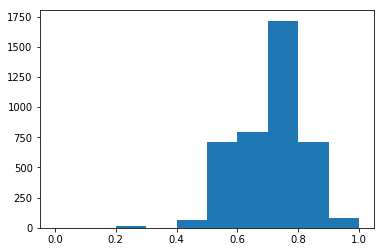

Quantity Experiment Theory
E -0.020429190994122052 -0.024784307790324853
Var 0.00032515288158605486 0.0010481713577779703


(-0.020429190994122052, 0.00032515288158605486)

In [67]:
experiment(partial(compute_mean_and_var_bernoulli, threshold = lambda x : True, p = p))

### Experiment for two-sided Bernoulli

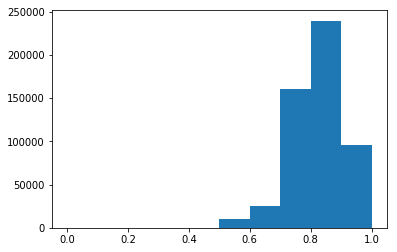

Quantity Experiment Theory
E -0.0034978733349180936 -0.0014018768724109306
Var 0.003031689143609067 0.0047285925914852655


(-0.0034978733349180936, 0.003031689143609067)

In [68]:
experiment(partial(compute_mean_and_var_bernoulli_twosided, threshold = lambda x : True, p = p))

### Is it true that $P\{u|\|u\|\geq\alpha \|w\|\}$ is small?

In [34]:
def compute_prob_delta_small(p, alpha_0 = 0.5):
    """ Compute expectation and variance of fcn given Bernoulli crashes w.p. p
        Two sided: w.p. p/2 +x, w.p. p/2 -x
    """
    # all combinations
    combinations = list(itertools.product([0, 1], repeat=len(x)))
    
    # number of entries in x
    n = len(x)

    # all probs
    probs = 0
    
    probs_small = 0
    deltas = {n_: [] for n_ in range(len(x) + 1)}
    
    for c in combinations:
        # crashing inputs
        x1 = np.multiply(x.reshape(-1), c)
        
        # number of crashes
        k = len(c) - np.sum(c)
        
        # probability of this event
        prob = p ** k * (1 - p) ** (n - k)
        
        # how much vector is changed in norm?
        alpha = np.linalg.norm(x.reshape(-1) - x1) ** 2 / np.linalg.norm(x) ** 2
        
        deltas[k].append(alpha)
        
        probs += prob
        
        if alpha <= alpha_0:
            probs_small += prob
    return (probs - probs_small) / probs, deltas

In [87]:
# deltas -- probability of having this particular number of crashes
p_, deltas = compute_prob_delta_small(p, 0.5)

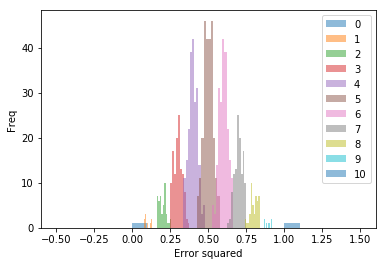

In [89]:
# plotting probability of error grouped by number of crashes
plt.figure()
plt.xlabel('Error squared')
plt.ylabel('Freq')
for k in sorted(deltas.keys()):
    h = deltas[k]
    plt.hist(h, alpha = 0.5, label = '%d' % k)
plt.legend()
plt.show()

Is it true that $P(\|u\|\geq\alpha\|w\|)$ is small? Answer: kinda for $\leq 3$ crashes $\alpha\leq 0.5$

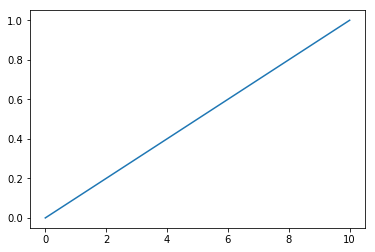

In [72]:
# Plotting squared norm change with growing f
plt.plot([np.mean(deltas[k]) for k in sorted(deltas.keys())])

#### Computing desired probability directly (cumulative p.f.)

In [90]:
def compute_prob(p, alpha_0 = 0.5):
    """ Compute expectation and variance of fcn given Bernoulli crashes w.p. p
        Two sided: w.p. p/2 +x, w.p. p/2 -x
    """
    # all combinations
    combinations = list(itertools.product([0, 1], repeat=len(x)))
    
    # number of entries in x
    n = len(x)

    # all probs
    probs = 0
    probs_arr = [0 for n_ in range(len(x) + 1)]
    
    for c in combinations:
        # crashing inputs
        x1 = np.multiply(x.reshape(-1), c)
        
        # number of crashes
        k = len(c) - np.sum(c)
        
        # probability of this event
        prob = p ** k * (1 - p) ** (n - k)
        
        probs_arr[k] += prob
        
        probs += prob
        
    return np.array(probs_arr) / probs

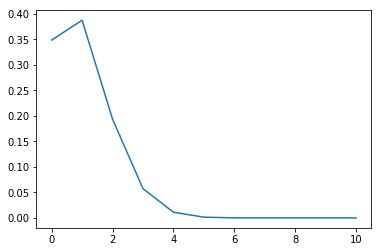

In [91]:
# probability of having k crashes
plt.plot(compute_prob(0.1))

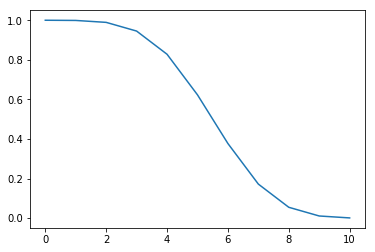

In [92]:
# probability of having >=k crashes
plt.plot(np.cumsum(compute_prob(0.5)[::-1])[::-1])

### Increasing size of x

In [33]:
def varDelta(d_ = 10):
    # generating x and w
    global x, d, w
    d = d_
    x = np.ones((d, 1))
    w = np.ones((d, 1)) / d
    varDelta = experiment(partial(compute_mean_and_var_bernoulli, threshold = lambda x : True, p = p))[1]
    return varDelta

  0%|          | 0/12 [00:00<?, ?it/s]

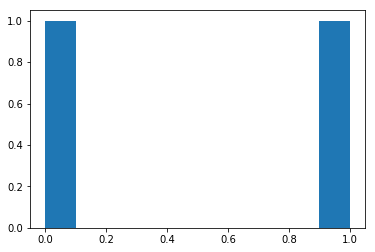

[-0.1] [0.09]
-0.02310585786300049 -0.026249269121992286
0.004804926008266635 0.005989550615874039


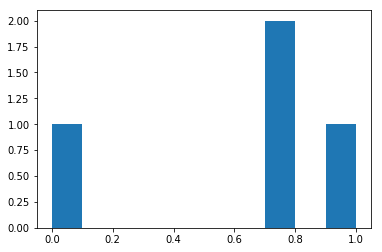

 17%|█▋        | 2/12 [00:00<00:00, 11.29it/s]

[-0.1 -0.1] [0.09 0.09]
-0.021858450323367105 -0.025450199304719028
0.0021789721945989844 0.0032942528387307213


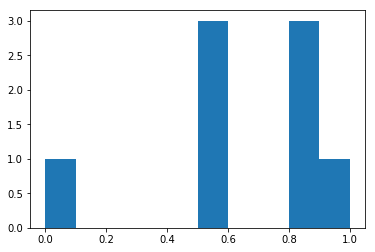

[-0.1 -0.1 -0.1] [0.09 0.09 0.09]
-0.021323681624155245 -0.025183842698961265
0.0013950095517780178 0.002395820246349615


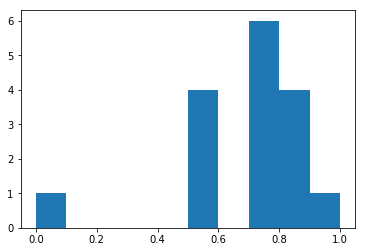

 33%|███▎      | 4/12 [00:00<00:00, 11.34it/s]

[-0.1 -0.1 -0.1 -0.1] [0.09 0.09 0.09 0.09]
-0.02103717761171509 -0.025050664396082396
0.0010234784227806412 0.0019466039501590628


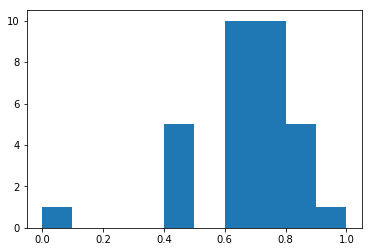

[-0.1 -0.1 -0.1 -0.1 -0.1] [0.09 0.09 0.09 0.09 0.09]
-0.020859529931298065 -0.02497075741435507
0.0008075378953964392 0.0016770741724447314


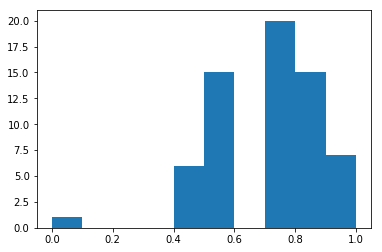

 50%|█████     | 6/12 [00:00<00:00, 11.18it/s]

[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1] [0.09 0.09 0.09 0.09 0.09 0.09]
-0.0207387919031001 -0.02491748609320352
0.0006665908871617143 0.0014973876539685098


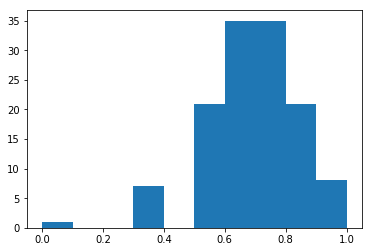

[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1] [0.09 0.09 0.09 0.09 0.09 0.09 0.09]
-0.020651449038167326 -0.024879435149523843
0.0005674245804661374 0.0013690401407712091


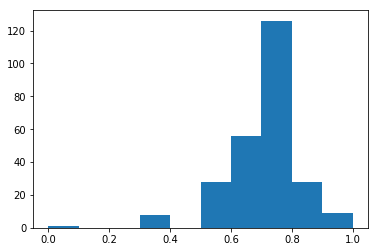

 67%|██████▋   | 8/12 [00:00<00:00, 10.24it/s]

[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1] [0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09]
-0.02058535053370673 -0.024850896941764095
0.00049388899247127 0.0012727795058732343


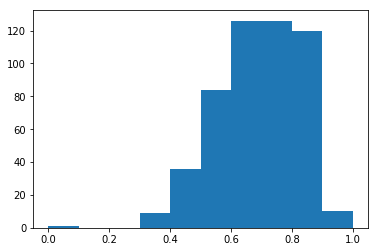

 75%|███████▌  | 9/12 [00:00<00:00,  9.06it/s]

[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1] [0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09]
-0.02053359504492548 -0.024828700557950917
0.00043719780264880485 0.0011979101231748062


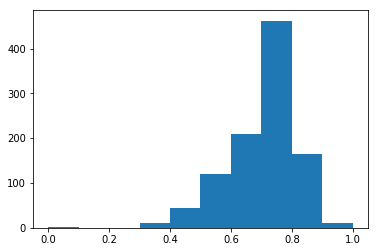

 83%|████████▎ | 10/12 [00:01<00:00,  7.46it/s]

[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1] [0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09]
-0.02049197536965389 -0.024810943450900364
0.00039216471695025564 0.001138014617016064


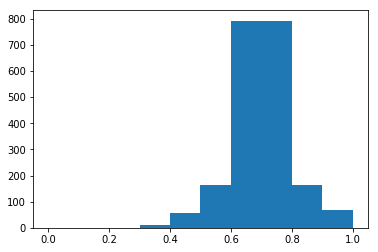

 92%|█████████▏| 11/12 [00:01<00:00,  5.42it/s]

[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1] [0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09]
-0.02045778184967693 -0.024796414908768143
0.00035553246597546116 0.0010890092028861867


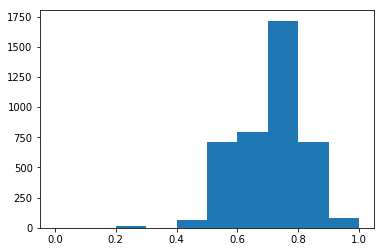

100%|██████████| 12/12 [00:01<00:00,  3.56it/s]

[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1] [0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09]
-0.020429190994122052 -0.024784307790324853
0.00032515288158605486 0.0010481713577779703


In [46]:
ks = np.arange(1, 13)
varDeltas = [varDelta(k) for k in tqdm(ks)]

In [61]:
def test_hyperbola(xs, ys):
    """ Test how much data looks like hyperbola y = 1/x """
    c, alpha = np.polyfit(np.log(xs), np.log(ys), 1)
    plt.plot(xs, ys)
    plt.show()
    plt.plot(np.log(xs), np.log(ys))
    print(c)

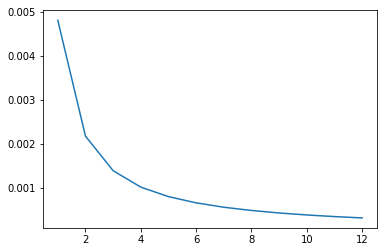

-1.0774410465753252


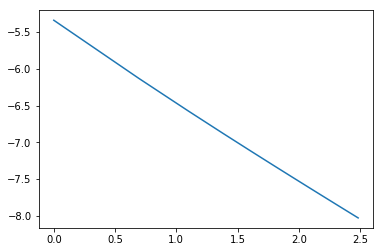

In [62]:
test_hyperbola(ks, varDeltas)

### Computing the probability that $\mathbb P\{|u|\geq \alpha|w|\}$ when $d$ increases

In [52]:
def compute_prob_delta_small_L1(p, alpha_0 = 0.5):
    """ Compute expectation and variance of fcn given Bernoulli crashes w.p. p
        Two sided: w.p. p/2 +x, w.p. p/2 -x
    """
    # all combinations
    combinations = list(itertools.product([0, 1], repeat=len(x)))
    
    # number of entries in x
    n = len(x)

    # all probs
    probs = 0
    probs_big = 0
    
    for c in combinations:
        # crashing inputs
        x1 = np.multiply(x.reshape(-1), c)
        
        # number of crashes
        k = len(c) - np.sum(c)
        
        # probability of this event
        prob = p ** k * (1 - p) ** (n - k)
        
        # how much vector is changed in norm?
        #alpha = np.linalg.norm(x.reshape(-1) - x1, ord = 1) / np.linalg.norm(x, ord = 1)
        alpha = k / len(c)
        
        probs += prob
        
        if alpha >= alpha_0:
            probs_big += prob
    return probs_big / probs

In [57]:
def prob_p_small(d_ = 10):
    # generating x and w
    global x, d, w
    d = d_
    x = np.ones((d, 1))
    w = np.ones((d, 1)) / d
    
    # fraction of faults
    alpha = 5 * p
    
    #print(p, alpha)
    
    # return probability of big failure
    return compute_prob_delta_small_L1(p, alpha)

In [58]:
ds = np.arange(1, 14)
Ps = [prob_p_small(d_) for d_ in tqdm(ds)]


100%|██████████| 13/13 [00:02<00:00,  3.31it/s]

In [59]:
Ps

[0.1,
 0.19,
 0.028000000000000004,
 0.05230000000000001,
 0.008560000000000002,
 0.015850000000000006,
 0.0027280000000000004,
 0.005024349999999996,
 0.0008909199999999967,
 0.0016349373999999973,
 0.0002957060800000021,
 0.0005412318219999941,
 9.928548640000351e-05]

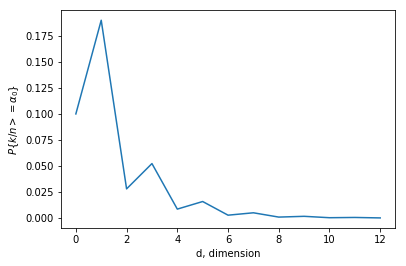

In [65]:
plt.xlabel('d, dimension')
plt.ylabel('$P\{k/n >= \\alpha_0\}$')
plt.plot(Ps)
plt.show()

Indeed, there is an exponential decrease overall